In [1]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['text.usetex'] = False
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.utils import check_random_state
from ForestDiffusion import ForestDiffusionModel
from utrees import UnmaskingTrees
from missforest import MissForest

In [2]:
# Iris: numpy dataset with 4 variables (all numerical) and 1 outcome (categorical)
my_data = load_iris()
X, y = my_data['data'], my_data['target']
Xy = np.concatenate((X, np.expand_dims(y, axis=1)), axis=1)
palette = {'setosa': 'red', 'versicolor': 'green', 'virginica': 'blue'} 
alpha = 0.6
rix = 0

In [3]:
forestflow = ForestDiffusionModel(
    X, label_y=y, diffusion_type='flow', 
    n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], n_jobs=-1, seed=rix)
Xy_gen_forestflow = forestflow.generate(batch_size=X.shape[0]) # last variable will be the label_y

forestvp = ForestDiffusionModel(
    X, label_y=y, diffusion_type='vp', 
    n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], n_jobs=-1, seed=rix)
Xy_gen_forestvp = forestvp.generate(batch_size=X.shape[0]) # last variable will be the label_y

utrees = UnmaskingTrees(random_state=rix)
utrees.fit(Xy, quantize_cols=['continuous']*4 + ['categorical'])
Xy_gen_utrees = utrees.generate(n_generate=X.shape[0]);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 92.90it/s]


In [4]:
X_mcar = X.copy()
rng = check_random_state(rix)
hasmissing = rng.normal(size=(150,)) < 0.
X_hasmissing = X_mcar[hasmissing, :]
X_hasmissing[rng.normal(size=X_hasmissing.shape) < 0] = np.nan
X_mcar[hasmissing, :] = X_hasmissing
Xy_mcar = np.concatenate((X_mcar, np.expand_dims(y, axis=1)), axis=1)
np.isnan(X_mcar).sum()

151

In [5]:
missfer = MissForest(random_state=rix)
Xy_impute_missf = missfer.fit_transform(Xy_mcar.copy(), cat_vars=[4])

forestvp_mcar = ForestDiffusionModel(
    X=Xy_mcar, diffusion_type='vp', 
    n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[4], int_indexes=[0], n_jobs=-1, seed=rix)
Xy_impute_forest_fast = forestvp_mcar.impute(k=1) # regular (fast)
Xy_impute_forest = forestvp_mcar.impute(repaint=True, r=10, j=5, k=1) # REPAINT (slow, but better)

utrees_mcar = UnmaskingTrees(random_state=rix)
utrees_mcar.fit(Xy_mcar, quantize_cols=['continuous']*4 + ['categorical'])
Xy_impute_utrees = utrees_mcar.impute(n_impute=1)[0, :, :]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 393.84it/s]


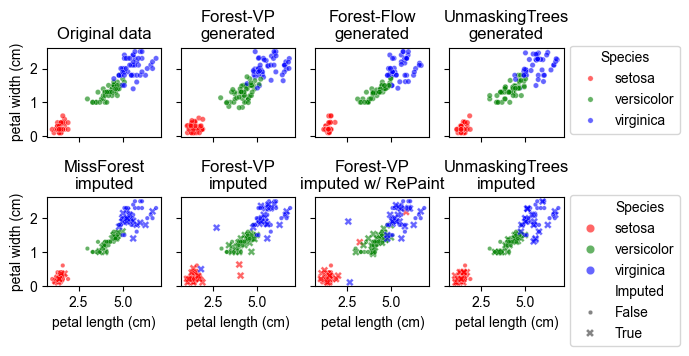

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7, 3.5), sharex=True, sharey=True, squeeze=False);

Xy_df = pd.DataFrame(data=Xy, columns=my_data['feature_names']+['target_names'])
Xy_df['Species'] = Xy_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_df, x='petal length (cm)', y='petal width (cm)', hue='Species', s=15,
    palette=palette, alpha=alpha, ax=axes[0, 0], legend=False)
axes[0, 0].set_title('Original data');

Xy_gen_forestvp_df = pd.DataFrame(data=Xy_gen_forestvp, columns=my_data['feature_names']+['target_names'])
Xy_gen_forestvp_df['Species'] = Xy_gen_forestvp_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_gen_forestvp_df, x='petal length (cm)', y='petal width (cm)', hue='Species', s=15,
    palette=palette, alpha=alpha, ax=axes[0, 1], legend=False)
axes[0, 1].set_title('Forest-VP\ngenerated');

Xy_gen_forestflow_df = pd.DataFrame(data=Xy_gen_forestflow, columns=my_data['feature_names']+['target_names'])
Xy_gen_forestflow_df['Species'] = Xy_gen_forestflow_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_gen_forestflow_df, x='petal length (cm)', y='petal width (cm)', hue='Species', s=15,
    palette=palette, alpha=alpha, ax=axes[0, 2], legend=False)
axes[0, 2].set_title('Forest-Flow\ngenerated');

Xy_gen_utrees_df = pd.DataFrame(data=Xy_gen_utrees, columns=my_data['feature_names']+['target_names'])
Xy_gen_utrees_df['Species'] = Xy_gen_utrees_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_gen_utrees_df, x='petal length (cm)', y='petal width (cm)', hue='Species', s=15,
    palette=palette, alpha=alpha, ax=axes[0, 3], legend=True)
axes[0, 3].set_title('UnmaskingTrees\ngenerated');

sns.move_legend(axes[0, 3], "upper left", bbox_to_anchor=(1, 1.1))

Xy_impute_missf_df = pd.DataFrame(data=Xy_impute_missf, columns=my_data['feature_names']+['target_names'])
Xy_impute_missf_df['Species'] = Xy_impute_missf_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_missf_df['Imputed'] = hasmissing
sns.scatterplot(
    data=Xy_impute_missf_df, x='petal length (cm)', y='petal width (cm)', hue='Species', style='Imputed',
    size='Imputed', sizes={False: 10, True: 30},
    palette=palette, alpha=alpha, ax=axes[1, 0], legend=False)
axes[1, 0].set_title('MissForest\nimputed');

Xy_impute_forest_fast_df = pd.DataFrame(data=Xy_impute_forest_fast, columns=my_data['feature_names']+['target_names'])
Xy_impute_forest_fast_df['Species'] = Xy_impute_forest_fast_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_forest_fast_df['Imputed'] = hasmissing
sns.scatterplot(
    data=Xy_impute_forest_fast_df, x='petal length (cm)', y='petal width (cm)', hue='Species', style='Imputed',
    size='Imputed', sizes={False: 10, True: 30},
    palette=palette, alpha=alpha, ax=axes[1, 1], legend=False)
axes[1, 1].set_title('Forest-VP\nimputed');

Xy_impute_forest_df = pd.DataFrame(data=Xy_impute_forest, columns=my_data['feature_names']+['target_names'])
Xy_impute_forest_df['Species'] = Xy_impute_forest_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_forest_df['Imputed'] = hasmissing
sns.scatterplot(
    data=Xy_impute_forest_df, x='petal length (cm)', y='petal width (cm)', hue='Species', style='Imputed',
    size='Imputed', sizes={False: 10, True: 30},
    palette=palette, alpha=alpha, ax=axes[1, 2], legend=False)
axes[1, 2].set_title('Forest-VP\nimputed w/ RePaint');

Xy_impute_utrees_df = pd.DataFrame(data=Xy_impute_utrees, columns=my_data['feature_names']+['target_names'])
Xy_impute_utrees_df['Species'] = Xy_impute_utrees_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_utrees_df['Imputed'] = hasmissing

sns.scatterplot(
    data=Xy_impute_utrees_df, x='petal length (cm)', y='petal width (cm)', hue='Species', style='Imputed',
    size='Imputed', sizes={False: 10, True: 30},
    palette=palette, alpha=alpha, ax=axes[1, 3], legend=True)
axes[1, 3].set_title('UnmaskingTrees\nimputed');
sns.move_legend(axes[1, 3], "upper left", bbox_to_anchor=(1, 1.1))

plt.tight_layout();
plt.savefig('iris.png');

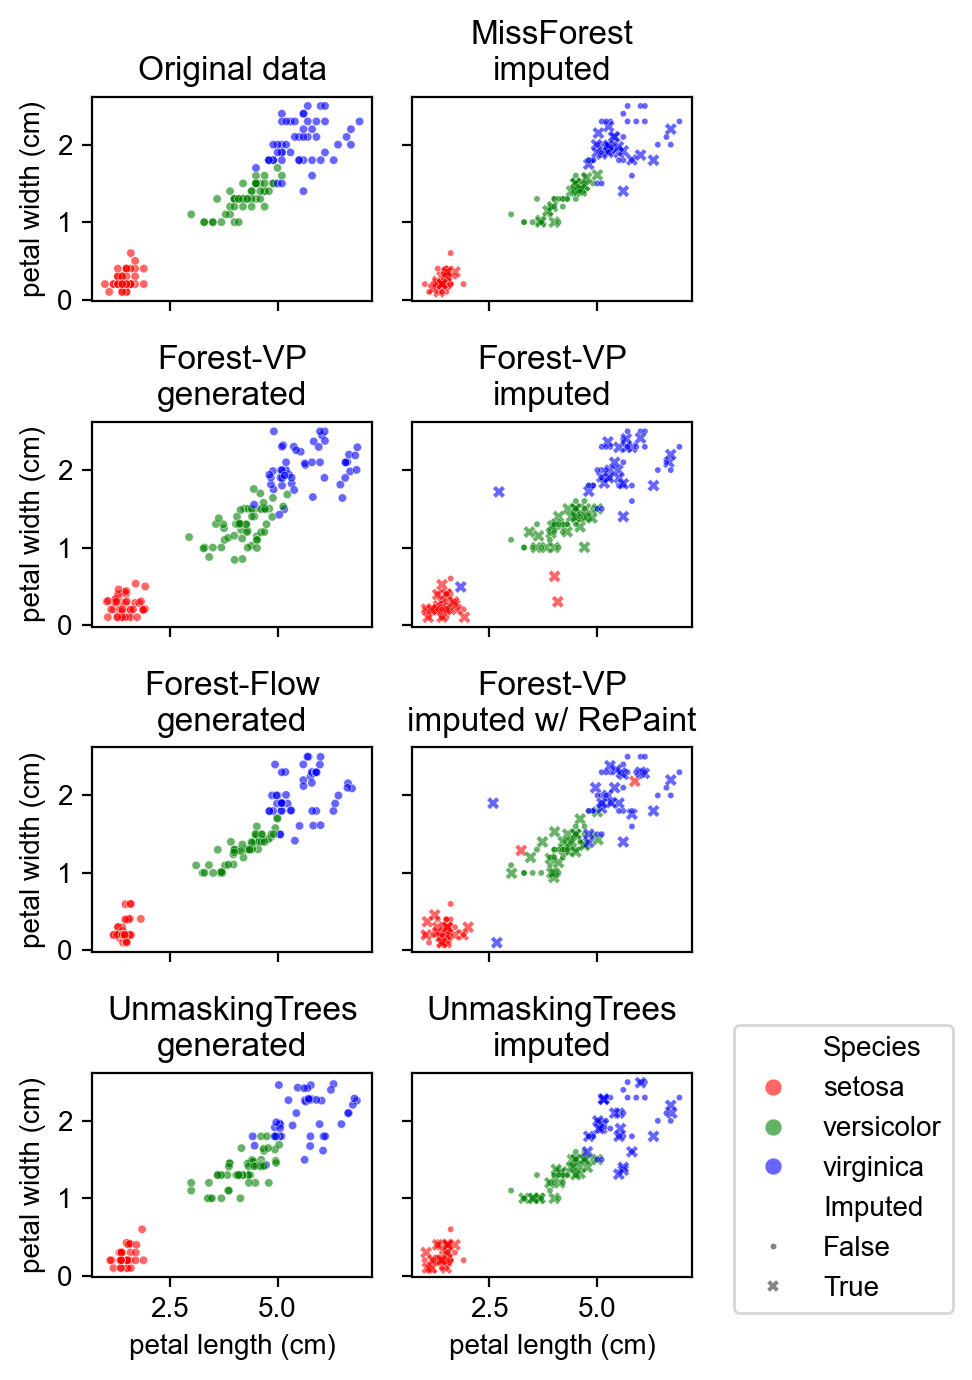

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(5, 7), dpi=200, sharex=True, sharey=True, squeeze=False);

Xy_df = pd.DataFrame(data=Xy, columns=my_data['feature_names']+['target_names'])
Xy_df['Species'] = Xy_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_df, x='petal length (cm)', y='petal width (cm)', hue='Species', s=9,
    palette=palette, alpha=alpha, ax=axes[0, 0], legend=False)
axes[0, 0].set_title('Original data');

Xy_gen_forestvp_df = pd.DataFrame(data=Xy_gen_forestvp, columns=my_data['feature_names']+['target_names'])
Xy_gen_forestvp_df['Species'] = Xy_gen_forestvp_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_gen_forestvp_df, x='petal length (cm)', y='petal width (cm)', hue='Species', s=9,
    palette=palette, alpha=alpha, ax=axes[1, 0], legend=False)
axes[1, 0].set_title('Forest-VP\ngenerated');

Xy_gen_forestflow_df = pd.DataFrame(data=Xy_gen_forestflow, columns=my_data['feature_names']+['target_names'])
Xy_gen_forestflow_df['Species'] = Xy_gen_forestflow_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_gen_forestflow_df, x='petal length (cm)', y='petal width (cm)', hue='Species', s=9,
    palette=palette, alpha=alpha, ax=axes[2, 0], legend=False)
axes[2, 0].set_title('Forest-Flow\ngenerated');

Xy_gen_utrees_df = pd.DataFrame(data=Xy_gen_utrees, columns=my_data['feature_names']+['target_names'])
Xy_gen_utrees_df['Species'] = Xy_gen_utrees_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
sns.scatterplot(
    data=Xy_gen_utrees_df, x='petal length (cm)', y='petal width (cm)', hue='Species', s=9,
    palette=palette, alpha=alpha, ax=axes[3, 0], legend=False)
axes[3, 0].set_title('UnmaskingTrees\ngenerated');

#sns.move_legend(axes[3, 0], "upper left", bbox_to_anchor=(1, 1.1))

Xy_impute_missf_df = pd.DataFrame(data=Xy_impute_missf, columns=my_data['feature_names']+['target_names'])
Xy_impute_missf_df['Species'] = Xy_impute_missf_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_missf_df['Imputed'] = hasmissing
sns.scatterplot(
    data=Xy_impute_missf_df, x='petal length (cm)', y='petal width (cm)', hue='Species', style='Imputed',
    size='Imputed', sizes={False: 5, True: 20},
    palette=palette, alpha=alpha, ax=axes[0, 1], legend=False)
axes[0, 1].set_title('MissForest\nimputed');

Xy_impute_forest_fast_df = pd.DataFrame(data=Xy_impute_forest_fast, columns=my_data['feature_names']+['target_names'])
Xy_impute_forest_fast_df['Species'] = Xy_impute_forest_fast_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_forest_fast_df['Imputed'] = hasmissing
sns.scatterplot(
    data=Xy_impute_forest_fast_df, x='petal length (cm)', y='petal width (cm)', hue='Species', style='Imputed',
    size='Imputed', sizes={False: 5, True: 20},
    palette=palette, alpha=alpha, ax=axes[1, 1], legend=False)
axes[1, 1].set_title('Forest-VP\nimputed');

Xy_impute_forest_df = pd.DataFrame(data=Xy_impute_forest, columns=my_data['feature_names']+['target_names'])
Xy_impute_forest_df['Species'] = Xy_impute_forest_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_forest_df['Imputed'] = hasmissing
sns.scatterplot(
    data=Xy_impute_forest_df, x='petal length (cm)', y='petal width (cm)', hue='Species', style='Imputed',
    size='Imputed', sizes={False: 5, True: 20},
    palette=palette, alpha=alpha, ax=axes[2, 1], legend=False)
axes[2, 1].set_title('Forest-VP\nimputed w/ RePaint');

Xy_impute_utrees_df = pd.DataFrame(data=Xy_impute_utrees, columns=my_data['feature_names']+['target_names'])
Xy_impute_utrees_df['Species'] = Xy_impute_utrees_df['target_names'].apply(lambda x: my_data['target_names'][int(x)].item())
Xy_impute_utrees_df['Imputed'] = hasmissing

sns.scatterplot(
    data=Xy_impute_utrees_df, x='petal length (cm)', y='petal width (cm)', hue='Species', style='Imputed',
    size='Imputed', sizes={False: 5, True: 20},
    palette=palette, alpha=alpha, ax=axes[3, 1], legend=True)
axes[3, 1].set_title('UnmaskingTrees\nimputed');
sns.move_legend(axes[3, 1], "upper left", bbox_to_anchor=(1.1, 1.3))

plt.tight_layout();
plt.savefig('iris-vertical.png');
plt.savefig('iris-vertical.pdf');